In [1]:
import os
import time
import argparse
import numpy as np
import scipy.io as sio
from copy import deepcopy
from einops import rearrange
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch import optim
import torch.utils.data as Data
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from data_prepare import mirror_hsi
from data_prepare import choose_train_and_test
from data_prepare import choose_all_pixels, all_data
from data_prepare import train_and_test_data, train_and_test_label


from Utils import AverageMeter, accuracy
from Utils import output_metric, plot_confusion_matrix
from Utils import list_to_colormap, classification_map, print_args


import math
import pickle
from operator import truediv
from datetime import datetime


%matplotlib inline

In [2]:
parser = argparse.ArgumentParser("DMCN")
parser.add_argument('--dataset', choices=['HU2013', 'Salinas', 'HongHu', 'KSC'], default='Salinas', help='dataset to use')
parser.add_argument('--seed', type=int, default=42, help='number of seed')
parser.add_argument('--batch_size', type=int, default=32, help='number of batch size')
parser.add_argument('--patch_size', type=int, default=15, help='size of patches')
parser.add_argument('--epoches', type=int, default=100, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=5e-3, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.99, help='gamma')
parser.add_argument('--weight_decay', type=float, default=0.001, help='weight_decay')
parser.add_argument('--train_number', type=int, default=10, help='num_train_per_class')
args = parser.parse_args(args=[])

In [3]:
# prepare data
data_path = os.path.join(os.getcwd(), 'dataset')

if args.dataset == 'HU2013':
    data = sio.loadmat(os.path.join(data_path, 'Houston.mat'))['Houston']
    label = sio.loadmat(os.path.join(data_path, 'Houston_gt.mat'))['Houston_gt']
elif args.dataset == 'HanChuan':
    data = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan.mat'))['WHU_Hi_HanChuan']
    label = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan_gt.mat'))['WHU_Hi_HanChuan_gt']
elif args.dataset == 'KSC':
    data = sio.loadmat(os.path.join(data_path, 'KSC.mat'))['KSC']
    label = sio.loadmat(os.path.join(data_path, 'KSC_gt.mat'))['KSC_gt']
elif args.dataset == 'Salinas':
    data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
    label = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
else:
    raise ValueError("Unknown dataset")

num_classes = np.max(label)
print('The class numbers of the HSI data is:', num_classes)

The class numbers of the HSI data is: 16


In [4]:
shapeor = data.shape
data = data.reshape(np.prod(data.shape[:2]), np.prod(data.shape[2:]))

std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(data)
data = std_data.reshape(shapeor)

In [5]:
def applyPCA(data, numComponents=30):
    new_data = np.reshape(data, (-1, data.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    new_data = pca.fit_transform(new_data)
    new_data = np.reshape(new_data, (data.shape[0], data.shape[1], numComponents))
    return new_data, pca

In [6]:
K = 30
data, pca = applyPCA(data, numComponents=K)

# data size
height, width, band = data.shape
print("height={0}, width={1}, band={2}".format(height, width, band))

height=512, width=217, band=30


In [7]:
mirror_data = mirror_hsi(height, width, band, data, patch_size=args.patch_size)

*******************************************************
patch_size : 15
mirror_data shape : [526, 231, 30]
*******************************************************


In [8]:
total_pos_train, total_pos_test, total_pos_valid, number_train, number_test, number_valid = choose_train_and_test(label, args.train_number, args.seed) 

x_train, x_test, x_valid = train_and_test_data(mirror_data, band, total_pos_train, total_pos_test, total_pos_valid, args.patch_size)
y_train, y_test, y_valid = train_and_test_label(number_train, number_test, number_valid, num_classes)

*******************************************************
x_train shape = (160, 15, 15, 30), type = float64
x_test  shape = (53969, 15, 15, 30), type = float64
x_valid  shape = (1600, 15, 15, 30), type = float64
*******************************************************
y_train: shape = (160,), type = int64
y_test: shape = (53969,), type = int64
y_valid: shape = (1600,), type = int64
*******************************************************


In [9]:
total_pos_train[:10]

array([[268,  24],
       [245,  47],
       [242,  56],
       [263,  38],
       [243,  49],
       [246,  49],
       [257,  21],
       [243,  45],
       [247,  36],
       [245,  51]])

In [10]:
# load data
x_train = torch.from_numpy(x_train.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (90, 1, 7, 7, 176)
print(x_train.shape)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # (13,)
train_label = Data.TensorDataset(x_train, y_train)

x_test = torch.from_numpy(x_test.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5198, 1, 7, 7, 176)
print(x_test.shape)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)  # (5198,)
test_label = Data.TensorDataset(x_test, y_test)

x_valid = torch.from_numpy(x_valid.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5211, 1, 7, 7, 176)
print(x_valid.shape)
y_valid = torch.from_numpy(y_valid).type(torch.LongTensor)
valid_label = Data.TensorDataset(x_valid, y_valid)

train_loader = Data.DataLoader(train_label, batch_size=32, shuffle=True)
test_loader = Data.DataLoader(test_label, batch_size=128, shuffle=True)
valid_loader = Data.DataLoader(valid_label, batch_size=64, shuffle=True)

torch.Size([160, 30, 15, 15])
torch.Size([53969, 30, 15, 15])
torch.Size([1600, 30, 15, 15])


## **Model**

#### Capsule Network Model

In [11]:
class PrimaryCaps(nn.Module):
    
    def __init__(self, A=64, B=32, K=1, P=4, stride=1):
        super(PrimaryCaps, self).__init__()
        self.pose = nn.Conv2d(in_channels=A, out_channels=B*P*P, kernel_size=K, stride=stride, bias=True)
        self.a = nn.Conv2d(in_channels=A, out_channels=B,
                            kernel_size=K, stride=stride, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        p = self.pose(x)  # (batch, 32x4x4, 13, 13)
        a = self.a(x)  # (batch, 32, 13, 13)
        a = self.sigmoid(a)
        out = torch.cat([p, a], dim=1)
        out = out.permute(0, 2, 3, 1)
        return out  # (batch, 13, 13, 544)

In [12]:
class ConvCaps(nn.Module):
    def __init__(self, B=32, C=16, K=3, P=4, stride=2, iters=3, coor_add=False, w_shared=False):
        super(ConvCaps, self).__init__()
        self.B = B
        self.C = C
        self.K = K
        self.P = P
        self.psize = P * P  # 16
        self.stride = stride
        self.iters = iters  # 3
        self.coor_add = coor_add
        self.w_shared = w_shared
        self.eps = 1e-07
        self._lambda = 1e-02
        self.ln_2pi = torch.cuda.FloatTensor(1).fill_(math.log(2*math.pi))  # tensor([1.8379])
        
        self.beta_u = nn.Parameter(torch.zeros(C))
        self.beta_a = nn.Parameter(torch.zeros(C))
        self.pos_embedding = nn.Parameter(torch.randn(1, 4, 4, B, C, P*P))
        self.weights = nn.Parameter(torch.randn(1, K*K*B, C, P, P))  # (1, 3x3x32, 16, 4, 4) 类似胶囊网络中的权重 or (1, 1x1x16, 16, 4, 4)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=2)

    def add_patches(self, x, B, K, psize, stride):
        b, h, w, c = x.shape  # (batch, 13, 13, 32*4*4+32)
        assert h == w
        assert c == B*(psize+1)
        oh = ow = int((h - K)/stride + 1)  # 6
        # [[0, 1, 2], [2, 3, 4], [4, 5, 6], [6, 7, 8], [8, 9, 10], [10, 11, 12]]
        idxs = [[(h_idx + k_idx) for k_idx in range(0, K)] for h_idx in range(0, h - K + 1, stride)]
        x = x[:, idxs, :, :]  # (batch, 6, 3, 13, 544)
        x = x[:, :, :, idxs, :]  # (batch, 6, 3, 6, 3, 544)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()  # (batch, 6, 6, 3, 3, 544)
        return x, oh, ow  # (batch, 6, 6, 3, 3, 544), 6, 6

    def transform_view(self, p_in, weights, C, P, w_shared=False):
        b, B, psize = p_in.shape  # (batchx6x6, 3x3x32, 16) or (batch, 4x4x16, 16) when stride=1
        assert psize == P*P
        p_in = p_in.view(b, B, 1, P, P)  # (batchx6x6, 3x3x32, 1, 4, 4) or (batch, 4x4x16, 1, 4, 4) 
        if w_shared:  # 所谓的权重共享并没有什么真正的意义，只是为了消除空间尺寸，获得最后的类别胶囊
            hw = int(B / weights.size(1))  # int(4x4x16 / 1x1x16) = 4x4
            weights = weights.repeat(1, hw, 1, 1, 1)  # (1, 4x4x16, 16, 4, 4)
        weights = weights.repeat(b, 1, 1, 1, 1)  # (batchx6x6, 3x3x32, 16, 4, 4) or (batch, 4x4x16, 16, 4, 4) 
        p_in = p_in.repeat(1, 1, C, 1, 1)  # (batchx6x6, 3x3x32, 16, 4, 4) or (batch, 4x4x16, 16, 4, 4)
        v = torch.matmul(p_in, weights)
        v = v.view(b, B, C, P*P)  # (batchx6x6, 3x3x32, 16, 16) 所有初级胶囊i对于所有胶囊j的投票结果 or (batch, 4x4x16, 16, 16)
        return v

    def add_coord(self, v, b, h, w, B, C, psize):
        # v: (batch, 4x4x16, 16, 16)
        assert h == w == 4
        v = v.view(b, h, w, B, C, psize)  # (batch, 4, 4, 16, 16, 16)
        v = v + self.pos_embedding
        v = v.view(b, h*w*B, C, psize)  # (batch, 4x4x16, 16, 16)
        return v

    def m_step(self, a_in, r, v, eps, b, B, C, psize, iter):
        # a_in: (batchx6x6, 3x3x32, 1); r: (batchx6x6, 3x3x32, 16); v: (batchx6x6, 3x3x32, 16, 16)
        r = r * a_in  # (batchx6x6, 3x3x32, 16) 这里的16表示每个位置的父胶囊的个数
        r = r / (r.sum(dim=2, keepdim=True) + eps)  # (batchx6x6, 3x3x32, 16) 这一步的目的是使r重新表示成概率(和为1)
        r_sum = r.sum(dim=1, keepdim=True)  # (batchx6x6, 1, 16) 这里的3x3x32可以看作巻积胶囊层中初级胶囊的个数
        coeff = r / (r_sum + eps)  # (batchx6x6, 3x3x32, 16)
        coeff = coeff.view(b, B, C, 1)  # (batchx6x6, 3x3x32, 16, 1) 

        mu = torch.sum(coeff * v, dim=1, keepdim=True)  # (batchx6x6, 1, 16, 16)  均值
        # 这里的代码实现先计算了一个coeff，对应M-Step中的第二步，并没有错哦，只是有点儿巧妙
        sigma_sq = torch.sum(coeff * (v - mu)**2, dim=1, keepdim=True) + eps  # (batchx6x6, 1, 16, 16)  方差

        r_sum = r_sum.view(b, C, 1)  # (batchx6x6, 16, 1)
        sigma_sq = sigma_sq.view(b, C, psize)  # (batchx6x6, 16, 16)
        #cost_h = (0.5 + 0.5*math.log(2*math.pi) + torch.log(sigma_sq.sqrt())) * r_sum  # (batchx6x6, 16, 16)
        cost_h = (self.beta_u.view(C, 1) + torch.log(sigma_sq.sqrt())) * r_sum  # (batchx6x6, 16, 16)

        #a_out = self.sigmoid((self._lambda*(1-0.95**(iter+1)))*(self.beta_a - self.beta_u * r_sum.view(b, C) - cost_h.sum(dim=2)))  # (batchx6x6, 16)
        a_out = self.sigmoid((self._lambda*(1-0.95**(iter+1)))*(self.beta_a - cost_h.sum(dim=2)))  # cost_h.sum(dim=2)表示对每个父胶囊在特征维度求和 (batchx6x6, 16)
        sigma_sq = sigma_sq.view(b, 1, C, psize)  # (batchx6x6, 1, 16, 16)

        return a_out, mu, sigma_sq  # (batchx6x6, 16), (batchx6x6, 1, 16, 16), (batchx6x6, 1, 16, 16) 父胶囊激活，父胶囊分布的均值，父胶囊分布的方差

    def e_step(self, mu, sigma_sq, a_out, v, eps, b, C):
        # v: (batchx6x6, 3x3x32, 16, 16)
        ln_p_j_h = -1. * (v - mu) ** 2 / (2 * sigma_sq) - torch.log(sigma_sq.sqrt()) - 0.5 * self.ln_2pi  # 太过于精彩!!!!!看到这里你豁然开朗了吗？？？
        # 这一步在计算所有初级胶囊的投票与父胶囊分布的均值之间的相似性，根据这个相似性来重新计算概率分配，你，懂了吗？？？ (batchx6x6, 3x3x32, 16, 16) 
        ln_ap = ln_p_j_h.sum(dim=3) + torch.log(a_out.view(b, 1, C))  # 那既然对p_j_h求对数了，也要对a求对数  (batchx6x6, 3x3x32, 16)
        r = self.softmax(ln_ap)  # 重新计算的概率分配 (batchx6x6, 3x3x32, 16)
        return r

    def caps_em_routing(self, v, a_in, C, eps):
        b, B, c, psize = v.shape  # (batchx6x6, 3x3x32, 16, 16)
        assert c == C
        assert (b, B, 1) == a_in.shape  # (batchx6x6, 3x3x32, 1)

        r = torch.cuda.FloatTensor(b, B, C).fill_(1./C)  # (batchx6x6, 3x3x32, 16) 分配概率rij(和为1)
        for iter_ in range(self.iters):
            a_out, mu, sigma_sq = self.m_step(a_in, r, v, eps, b, B, C, psize, iter_)  
            # (batchx6x6, 16), (batchx6x6, 1, 16, 16), (batchx6x6, 1, 16, 16) 父胶囊激活，父胶囊分布的均值，父胶囊分布的方差
            if iter_ < self.iters - 1:
                r = self.e_step(mu, sigma_sq, a_out, v, eps, b, C)  # 更新分配概率(batchx6x6, 3x3x32, 16)

        return mu, a_out  # (batchx6x6, 1, 16, 16), (batchx6x6, 16) 

    def forward(self, x):
        b, h, w, c = x.shape  # (batch, 13, 13, 544) or (batch, 4, 4, (16+1)*16)
        if not self.w_shared:
            x, oh, ow = self.add_patches(x, self.B, self.K, self.psize, self.stride)  # (batch, 6, 6, 3, 3, 544), 6, 6

            p_in = x[:, :, :, :, :, :self.B*self.psize].contiguous()  # (batch, 6, 6, 3, 3, 512)
            a_in = x[:, :, :, :, :, self.B*self.psize:].contiguous()  #  (batch, 6, 6, 3, 3, 32)
            p_in = p_in.view(b*oh*ow, self.K*self.K*self.B, self.psize)  # (batchx6x6, 3x3x32, 16) 这里的3x3x32可以看作巻积胶囊层中初级胶囊的个数
            a_in = a_in.view(b*oh*ow, self.K*self.K*self.B, 1)  # (batchx6x6, 3x3x32, 1)
            v = self.transform_view(p_in, self.weights, self.C, self.P)  # (batchx6x6, 3x3x32, 16, 16) 所有初级胶囊对所有父胶囊的投票

            p_out, a_out = self.caps_em_routing(v, a_in, self.C, self.eps)  # 返回父胶囊分布的均值(batchx6x6, 1, 16, 16)和父胶囊的激活(batchx6x6, 16)
            p_out = p_out.view(b, oh, ow, self.C*self.psize)  # （batch, 6, 6, 16x16）
            a_out = a_out.view(b, oh, ow, self.C)  # (batch, 6, 6, 16)
            out = torch.cat([p_out, a_out], dim=3)  # (batch, 6, 6, (16+1)x16)
        else:
            # x: (batch, 4, 4, (16+1)*16)
            assert c == self.B*(self.psize+1)
            assert 1 == self.K
            assert 1 == self.stride
            p_in = x[:, :, :, :self.B*self.psize].contiguous()  # (batch, 4, 4, 16*16)
            p_in = p_in.view(b, h*w*self.B, self.psize)  # (batch, 4x4x16, 16)
            a_in = x[:, :, :, self.B*self.psize:].contiguous()  # (batch, 4, 4, 16)
            a_in = a_in.view(b, h*w*self.B, 1)  # (batch, 4x4x16, 1)

            v = self.transform_view(p_in, self.weights, self.C, self.P, self.w_shared)  # (batch, 4x4x16, 16, 16)

            if self.coor_add:
                v = self.add_coord(v, b, h, w, self.B, self.C, self.psize)
            _, out = self.caps_em_routing(v, a_in, self.C, self.eps)  # 返回父胶囊的激活(batch, 16)
        return out

In [13]:
class CapsNet(nn.Module):

    def __init__(self, A=64, B=32, C=16, D=16, E=16, K=3, P=4, iters=3, pca_components=30):
        super(CapsNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=pca_components, out_channels=A, kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm2d(num_features=A, eps=0.001, momentum=0.1, affine=True)
        self.relu1 = nn.ReLU(inplace=False)
        self.primary_caps = PrimaryCaps(A, B, 1, P, stride=1)
        self.conv_caps1 = ConvCaps(B, C, K, P, stride=2, iters=iters)
        self.conv_caps2 = ConvCaps(C, D, K, P, stride=1, iters=iters)
        self.class_caps = ConvCaps(D, E, 1, P, stride=1, iters=iters, coor_add=True, w_shared=True)

    def forward(self, x):
        # x: (B, 30, 15, 15)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.primary_caps(x) # (batch, 13, 13, 544)
        x = self.conv_caps1(x)  # (batch, 6, 6, (16+1)x16)
        x = self.conv_caps2(x)  # (batch, 4, 4, (16+1)x16)
        x = self.class_caps(x)  # (batch, 16)
        return x

#### Loss Function

In [14]:
class SpreadLoss(_Loss):
    def __init__(self, m_min=0.2, m_max=0.5, num_class=9):
        super(SpreadLoss, self).__init__()
        self.m_min = m_min
        self.m_max = m_max
        self.num_class = num_class

    def forward(self, x, target, r):
        b, E = x.shape  # batch, 16
        assert E == self.num_class
        margin = self.m_min + (self.m_max - self.m_min)*r  # 0.2 + (0.5 - 0.2) * r

        at = torch.cuda.FloatTensor(b).fill_(0)  # (batch, )
        for i, a in enumerate(target):
            lb = int(a.item())  # 真实标签，整数值，并不是one-hot
            at[i] = x[i][lb]  # 对应真实标签的类别胶囊激活值
        at = at.view(b, 1).repeat(1, E)  # (batch, 16)

        zeros = x.new_zeros(x.shape)  # (batch, 16)
        loss = torch.max(margin - (at - x), zeros)  # (batch, 16)
        loss = loss**2
        loss = loss.sum() / b - margin**2 

        return loss

## **Training Setup**

In [15]:
# train model
def train(model, train_loader, criterion, optimizer, epoch):
    objs = AverageMeter()
    top1 = AverageMeter()
    train_len = len(train_loader)
    for batch_idx, (batch_data, batch_target) in enumerate(train_loader):
        batch_data = batch_data.cuda()
        batch_target = batch_target.cuda()   
        optimizer.zero_grad()
        batch_pred = model(batch_data)  # (batch, 13)
    
        r = (1.*(batch_idx+1) + (epoch-1)*train_len) / (epoch*train_len)  # 表示当前训练轮次的训练数据的进度条
        loss = criterion(batch_pred, batch_target, r)
        loss.backward()
        optimizer.step()
        
        prec1, t, p = accuracy(batch_pred, batch_target, topk=(1,))
        n = batch_data.shape[0]
        objs.update(loss.data, n)  # 计算所有训练样本的平均损失
        top1.update(prec1[0].data, n)  # 计算所有训练样本的平均准确率
    return top1.avg, objs.avg


# test model
def test(model, test_loader):
    tar = np.array([])
    pre = np.array([])
    with torch.no_grad():
        for batch_idx, (batch_data, batch_target) in enumerate(test_loader):
            batch_data = batch_data.cuda()
            batch_target = batch_target.cuda()
            
            batch_pred = model(batch_data)  # (batch, 13)
            _, pred = batch_pred.topk(1, axis=1)  # (100, 1)
            pp = pred.squeeze()  # (100, )
            
            tar = np.append(tar, batch_target.data.cpu().numpy())
            pre = np.append(pre, pp.data.cpu().numpy())
    return tar, pre


# train model
def valid(model, train_loader, criterion, epoch):
    model.eval()
    objs = AverageMeter()
    top1 = AverageMeter()
    train_len = len(train_loader)
    for batch_idx, (batch_data, batch_target) in enumerate(train_loader):
        batch_data = batch_data.cuda()
        batch_target = batch_target.cuda()   
        
        batch_pred = model(batch_data)  # (batch, 13)
        
        r = (1.*(batch_idx+1) + (epoch-1)*train_len) / (epoch*train_len)  # 表示当前训练轮次的训练数据的进度条
        loss = criterion(batch_pred, batch_target, r)
        
        prec1, t, p = accuracy(batch_pred, batch_target, topk=(1,))
        n = batch_data.shape[0]
        objs.update(loss.data, n)  # 计算所有训练样本的平均损失
        top1.update(prec1[0].data, n)  # 计算所有训练样本的平均准确率
    return top1.avg, objs.avg

## **Training Process**

#### Model Initialization

In [16]:
model = CapsNet(A=64, B=32, C=16, D=16, E=num_classes, iters=2).cuda()
criterion = SpreadLoss(num_class=num_classes, m_min=0.2, m_max=0.9)
optimizer = optim.Adam(model.parameters(), lr = args.learning_rate, weight_decay=args.weight_decay)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.gamma)

In [17]:
print('start training')
acc_list = [0.00]
path = './model/DMC.pt'
tic = time.time()
for epoch in range(1, args.epoches+1):
    # 计算的是移动平均准确率
    train_acc, train_loss = train(model, train_loader, criterion, optimizer, epoch)
    valid_acc, valid_loss = valid(model, valid_loader, criterion, epoch)
    print("Epoch: {:03d} - train_loss: {:.4f} - train_acc: {:.4f} - valid_loss: {:.4f} - valid_acc: {:.4f}".\
          format(epoch, train_loss, train_acc, valid_loss, valid_acc))
    scheduler.step()

    acc_list.append(valid_acc)
    if acc_list[-1] > acc_list[-2]:
        print("val_acc improved from {:.4f} to {:.4f}, saving model to DMC.pt".format(acc_list[-2], acc_list[-1]))
        torch.save(model.state_dict(), path)
    else:
        print("val_acc did not improve from {:.4f}".format(acc_list[-2]))
        acc_list[-1] = acc_list[-2]

toc = time.time()
print("Running Time: {:.2f}".format(toc-tic))
print("**************************************************")

start training
Epoch: 001 - train_loss: 6.3565 - train_acc: 6.2500 - valid_loss: 5.3724 - valid_acc: 6.2500
val_acc improved from 0.0000 to 6.2500, saving model to DMC.pt
Epoch: 002 - train_loss: 8.7740 - train_acc: 7.5000 - valid_loss: 8.1332 - valid_acc: 12.4375
val_acc improved from 6.2500 to 12.4375, saving model to DMC.pt
Epoch: 003 - train_loss: 9.7007 - train_acc: 18.1250 - valid_loss: 9.2091 - valid_acc: 26.3750
val_acc improved from 12.4375 to 26.3750, saving model to DMC.pt
Epoch: 004 - train_loss: 10.0887 - train_acc: 30.0000 - valid_loss: 9.6744 - valid_acc: 31.8750
val_acc improved from 26.3750 to 31.8750, saving model to DMC.pt
Epoch: 005 - train_loss: 10.2122 - train_acc: 41.8750 - valid_loss: 9.8721 - valid_acc: 44.9375
val_acc improved from 31.8750 to 44.9375, saving model to DMC.pt
Epoch: 006 - train_loss: 10.1762 - train_acc: 53.1250 - valid_loss: 9.8401 - valid_acc: 55.7500
val_acc improved from 44.9375 to 55.7500, saving model to DMC.pt
Epoch: 007 - train_loss: 9.9

In [18]:
model.load_state_dict(torch.load(path))
model.eval()

tar_test, pre_test = test(model, test_loader)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)
AA_test = np.around(AA_test*100, 2)

In [19]:
print("*******************************************************************")
print("Final result:")
print("OA: {:.2f}, AA: {:.2f}, Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print("*******************************************************************")
print("Recal: {}".format(AA_test))
print("*******************************************************************")
print("Parameter:")
print_args(vars(args))
print("*******************************************************************")

*******************************************************************
Final result:
OA: 93.78, AA: 97.34, Kappa: 0.9309
*******************************************************************
Recal: [ 93.   100.   100.   100.    98.05 100.   100.    78.4  100.    98.04
 100.   100.   100.   100.    91.02  98.94]
*******************************************************************
Parameter:
dataset: Salinas
seed: 42
batch_size: 32
patch_size: 15
epoches: 100
learning_rate: 0.005
gamma: 0.99
weight_decay: 0.001
train_number: 10
*******************************************************************


In [20]:
average_accuracy = str(list(AA_test))
file_name = "./CR/dmcn_1.txt"

with open(file_name, 'w') as x_file:
    x_file.write("[{:.2f}, {:.2f}, {:.4f}]".format(OA_test * 100., AA_mean_test*100., Kappa_test))
    x_file.write('\n')
    x_file.write('{}'.format(average_accuracy))

## Panoramic Classification

In [21]:
def output_label(model, loader):
    model.eval()
    pre = np.array([]).astype('int')
    with torch.no_grad():
        for batch_idx, (batch_data, batch_target) in enumerate(loader):
            batch_data = batch_data.cuda()
            batch_pred = model(batch_data)  # (B, 9)
            _, pred = batch_pred.topk(1, axis=1)  # (B, 1)
            pp = pred.squeeze()
            pre = np.append(pre, pp.data.cpu().numpy())
    return pre

In [22]:
pos_forward, pos_backward = choose_all_pixels(label)

x_forward, x_backward, y_forward, y_backward = all_data(mirror_data, band, pos_forward, pos_backward, patch_size=args.patch_size)

*******************************************************
x_forward shape = (54129, 15, 15, 30), type = float64
x_backward  shape = (56975, 15, 15, 30), type = float64
*******************************************************


In [23]:
# load data
x_forward = torch.from_numpy(x_forward.transpose(0, 3, 1, 2)).type(torch.FloatTensor)
print(x_forward.shape)
y_forward = torch.from_numpy(y_forward).type(torch.LongTensor)  # (13,)
forward_label = Data.TensorDataset(x_forward, y_forward)

x_backward = torch.from_numpy(x_backward.transpose(0, 3, 1, 2)).type(torch.FloatTensor)
print(x_backward.shape)
y_backward = torch.from_numpy(y_backward).type(torch.LongTensor)  # (13,)
backward_label = Data.TensorDataset(x_backward, y_backward)

forward_loader = Data.DataLoader(forward_label, batch_size=128, shuffle=False)
backward_loader = Data.DataLoader(backward_label, batch_size=128, shuffle=False)

torch.Size([54129, 30, 15, 15])
torch.Size([56975, 30, 15, 15])


In [24]:
# output classification maps
pre_forward = output_label(model, forward_loader)
pre_backward = output_label(model, backward_loader)

prediction_matrix = np.zeros((height, width), dtype=float)
for i in range(pos_forward.shape[0]):
    prediction_matrix[pos_forward[i, 0], pos_forward[i, 1]] = pre_forward[i] + 1

for j in range(pos_backward.shape[0]):
    prediction_matrix[pos_backward[j, 0], pos_backward[j, 1]] = pre_backward[j] + 1

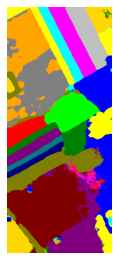

In [26]:
predict_map = list_to_colormap(prediction_matrix.ravel())
predict_map = np.reshape(predict_map, (height, width, 3))

classification_map(predict_map, './salinas_dmcn.pdf')